# Init

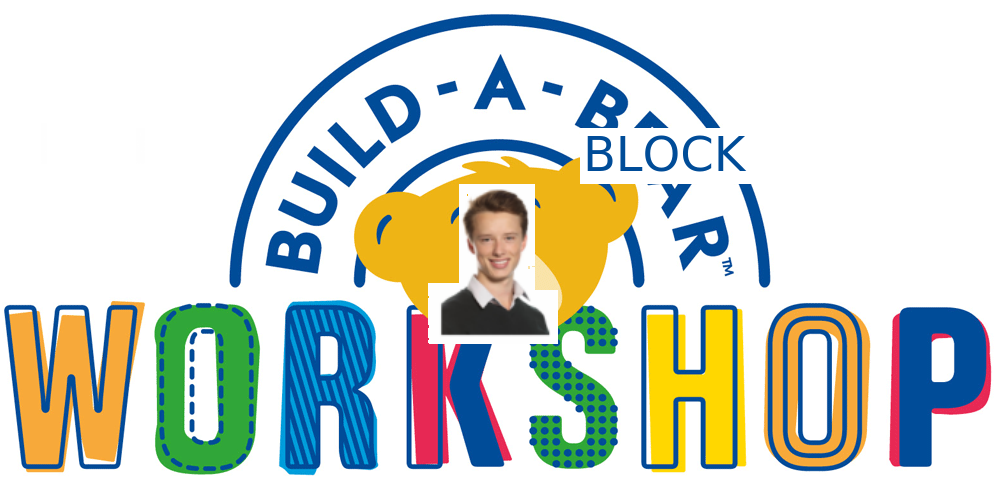

In [ ]:
from pycqedscripts.init.xld.virtual_ATC66_M124_S7P11_PQSC import *
from pycqedscripts.init.xld.cz_ATC66_M124_S7P11 import *
upcz_pulse_names = add_all_CZ_pulses(qubits)

In [ ]:
# Import latest configuration:
# timestamp = None

day = '20200322'
timestamp = a_tools.get_timestamps_in_range(day+'_000000',day+'_235959')[-1]

#Import from timestamp
# timestamp = '20200220_131405'

for qb in qubits:
    gen.load_settings(qb, timestamp=timestamp)

# corrections:
for qb in qubits:
    qb.ro_phase_lock(False) # for changes in pulse cleanup
    
clear_output()
print('Done.')

In [ ]:
from pycqed.measurement.waveform_control import segment, sequence
from pycqed.measurement.waveform_control.circuit_builder import CircuitBuilder
from pycqed.measurement.waveform_control.block import Block
channel_map={qb.name: [qb.ge_I_channel(), qb.ro_I_channel(), f'AWG1_ch{qb.name[-1]}'] for qb in [qb1,qb3,qb4]}

# Circuit Builder

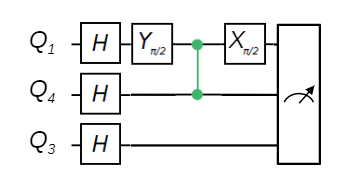

In [ ]:
qbs = [qb1,qb4,qb3]
operations = ['Y90 qb1', 'CZ qb1 qb4', 'X90 qb1']

In [ ]:
def test_seq(qbs, operations,fill_values=None, pulse_modifs=None,):
    builder = CircuitBuilder(qbs)
    pulses = builder.initialize(init_state='+').build()
    pulses += builder.block_from_ops("Block1", operations, fill_values=fill_values, pulse_modifs=pulse_modifs).build()
    pulses += builder.mux_readout().build()

    seq = sequence.Sequence('Test sequence')
    seq.add(segment.Segment('Test', pulses))
    return seq

In [ ]:
seq = test_seq(qbs, operations)

# Sequence Plotting

In [ ]:
seq.plot()

In [ ]:
channel_map={qb.name: [qb.ge_I_channel(), qb.ro_I_channel(), f'AWG1_ch{qb.name[-1]}'] for qb in [qb1,qb3,qb4]}
seq.plot(channel_map=channel_map)

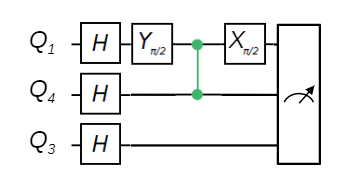

# Further Features

## Simple Sequence Creation with Circuit Builder

In [ ]:
operations = ['Y90 qb1', 'CZ qb1 qb4', 'X90 qb1', 'Y90s qb4']

In [ ]:
builder = CircuitBuilder(qbs)
seq = builder.seq_from_ops(operations, init_state='+')
seq.plot(channel_map=channel_map)

## Preparation

In [ ]:
qb1.preparation_params({'preparation_type': 'preselection', 'post_ro_wait': 5e-06})
seq = builder.seq_from_ops(operations, init_state='+')
seq.plot(channel_map=channel_map)

qb1.preparation_params({'preparation_type': 'wait', 'post_ro_wait': 5e-06})
seq = builder.seq_from_ops(operations, init_state='+')
seq.plot(channel_map=channel_map)

## Fill Values

In [ ]:
Had = ["Z180 {qbt}", "Y90 {qbt}"]
operations = ['CZ {qbc} {qbt}'] + Had + ['Z{angle} {qbt}'] + Had

phi = 30

seq = builder.seq_from_ops(operations, init_state='+', fill_values=dict(qbc='qb1', qbt='qb3', angle=2*phi))
seq.plot(channel_map=channel_map)

## Logical Indexing

In [ ]:
qbs = [qb1,qb4,qb3]
operations = ['Y90 0', 'CZ 0 1', 'X90 2']
seq = builder.seq_from_ops(operations, init_state='+')
seq.plot(channel_map=channel_map)

In [ ]:
qbs = [qb1,qb3,qb4]
seq = test_seq(qbs, operations)
seq.plot(channel_map=channel_map)

In [ ]:
# This will give an error due to missing connectivity
qbs = [qb3,qb4,qb1]
seq = test_seq(qbs, operations)
seq.plot(channel_map=channel_map)

# Working with Blocks

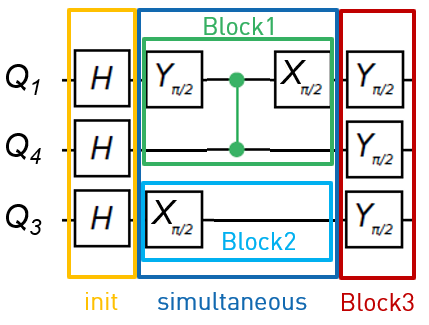

In [ ]:
qbs = [qb1,qb4,qb3]
builder = CircuitBuilder(qbs)

circ = Block("Test_Circuit", [])

init_block = builder.initialize(init_state='+')
circ.extend(init_block.build())

block1 = builder.block_from_ops("Block1", ['Y90 qb1', 'CZ qb1 qb4', 'X90 qb1'])
block2 = builder.block_from_ops("Block2", ['X90 qb3'])
block3 = builder.block_from_ops("Block3", ['Y90 qb1', 'Y90s qb3', 'Y90s qb4'])

simultaneous = Block("Simultaneous1", [])
simultaneous.extend(block2.build(ref_pulse=f"start"))
simultaneous.extend(block1.build(ref_pulse=f"start"))
circ.extend(simultaneous.build())

circ.extend(block3.build())

seq = sequence.Sequence('Test sequence')
seq.add(segment.Segment('Test', circ.build()))

seq.plot(channel_map=channel_map)

## Multiref Issue ==> Solution will be in Separate Pull Request

In [ ]:
qbs = [qb1,qb4,qb3]
builder = CircuitBuilder(qbs)

circ = Block("Test_Circuit", [])

init_block = builder.initialize(init_state='+')
circ.extend(init_block.build())

block1 = builder.block_from_ops("Block1", ['Y90 qb1', 'CZ qb1 qb4', 'X90 qb1'])
block2 = builder.block_from_ops("Block2", ['X90 qb3'])
block3 = builder.block_from_ops("Block3", ['Y90 qb1', 'Y90s qb3', 'Y90s qb4'])

simultaneous = Block("Simultaneous1", [])
simultaneous.extend(block1.build(ref_pulse=f"start"))
simultaneous.extend(block2.build(ref_pulse=f"start"))
circ.extend(simultaneous.build())

circ.extend(block3.build())

seq = sequence.Sequence('Test sequence')
seq.add(segment.Segment('Test', circ.build()))

seq.plot(channel_map=channel_map)

In [ ]:
# solution requires branch devel/multi_refpulse

qbs = [qb1,qb4,qb3]
builder = CircuitBuilder(qbs)

circ = Block("Test_Circuit", [])

init_block = builder.initialize(init_state='+')
circ.extend(init_block.build())

block1 = builder.block_from_ops("Block1", ['Y90 qb1', 'CZ qb1 qb4', 'X90 qb1'])
block2 = builder.block_from_ops("Block2", ['X90 qb3'])
block3 = builder.block_from_ops("Block3", ['Y90 qb1', 'Y90s qb3', 'Y90s qb4'])

# the following lines show how to solve the timing issue

simultaneous = Block("Simultaneous1", [])
simultaneous_end_pulses = []
for block in [block1, block2]:
    simultaneous.extend(block.build(ref_pulse=f"start"))
    simultaneous_end_pulses.append(simultaneous.pulses[-1]['name'])

# add a virtual pulse that references to the maximum end time of all pulses in simultaneous_end_pulses
if len(simultaneous_end_pulses) > 1:
    simultaneous.extend([{"name": f"simultaneous_end_pulse",
                          "pulse_type": "VirtualPulse",
                          "pulse_delay": 0,
                          "ref_pulse": simultaneous_end_pulses,
                          "ref_point": 'end',
                          "ref_function": 'max'
                         }])

circ.extend(simultaneous.build())

# the same can be done by using a new function in CircuitBuilder:
# circ.extend(builder.simultaneous_blocks('Simultaneous1', [block1, block2]).build())

circ.extend(block3.build())

seq = sequence.Sequence('Test sequence')
seq.add(segment.Segment('Test', circ.build()))

seq.plot(channel_map=channel_map)

# tikz Export ==> Will be in Separate Pull Request

In [ ]:
qbs = [qb1,qb4,qb3]
builder = CircuitBuilder(qbs)
Had = ["Z180 {qbt}", "Y90 {qbt}"]
operations = ['CZ {qbc} {qbt}'] + Had + ['Z{angle} {qbt}'] + Had
phi = 30
seq = builder.seq_from_ops(operations, init_state='+', fill_values=dict(qbc='qb1', qbt='qb3', angle=2*phi))

# Extract first segment
for seg in seq.segments.values():
    break

In [ ]:
# This requires the branch devel/block_advanced
[p.op_code for p in seg.unresolved_pulses]

In [ ]:
# This requires the branch devel/block_advanced
print(seg.export_tikz([qb.name for qb in qbs]))

# END